# Recall Adaline and Perceptron with Scikit-learn

In [48]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print("Class Labels: ", np.unique(y))

Class Labels:  [0 1 2]


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [50]:
print("Labels counts in y:", np.bincount(y))
print("Labels counts in y_train:", np.bincount(y_train))
print("Labels counts in y_test:", np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [51]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [52]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print(f"Misclassified examples: {(y_test != y_pred).sum()}")

Misclassified examples: 1


In [53]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy, 3)}")

Accuracy: 0.978


In [73]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # Setup marker generator and color map
    markers = ('s', '^', 'o', 'x', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          (np.arange(x2_min, x2_max, resolution)))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')
        
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='yellow', edgecolor='black', alpha=0.45,
                    linewidth=1, marker='o',
                    s=100, label='test set')

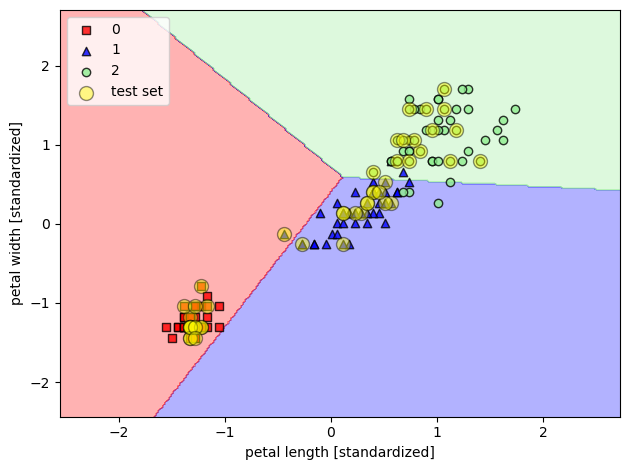

In [74]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Logistic Function

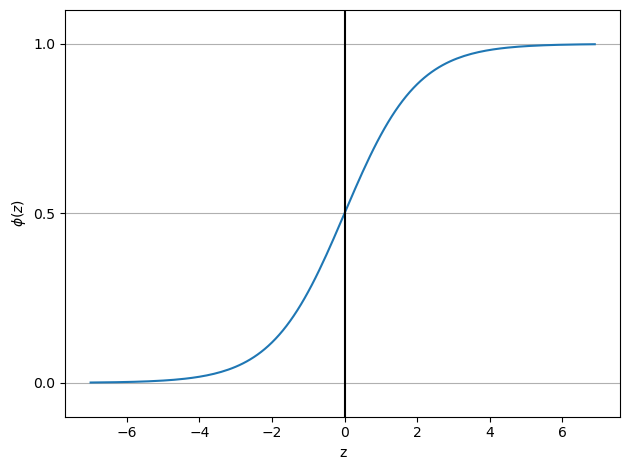

In [76]:
# Understanding sigmoid function

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

NOTES:
- $\phi (z)$ ==> 0.0 ; since z ==> $-\infty$ 
- $\phi (z)$ ==> 1.0 ; since z ==> $\infty$ 
- $\phi (z)$ = 0.5 when since z = 0.0

In [77]:
# Logistic Regression using Gradient Descent

class LogisticRegressionGD:
    """
    Logistic Regression Classifier using gradient descent 
        (implementation ADALINE gradient descent):
    
    Parameters
    -----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight
        initialization.
    
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Logistic cost function value in each epoch.
    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """
        Fit training data.
        
        Parameters
        -----------
        X : array-like, shape = [n_records, n_features]
            Training vectors, where n_records is the number of records
            of examples and n_features is the number of features.
        y : array-like, shape = [n_records]
            Target values.
            
        Returns
        ---------
        self : object
        """
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                             size=1 + X.shape[1])
        self.cost_ = []
        
        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            result = self.activation(net_input)
            errors = (y - result)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            cost = (-y.dot(np.log(result)) - 
                       (1 - y).dot(np.log(1 - result)))
        
        self.cost_.append(cost)
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
    # equivalent to:
    # return np.where(self.activation(self.net_input(X))
    # >= 0.5, 1, 0)

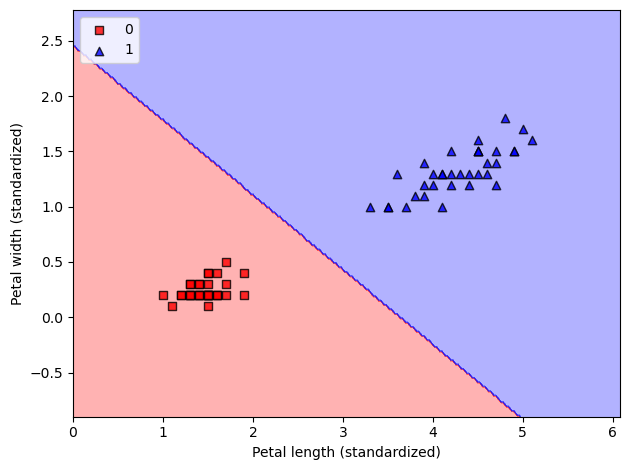

In [80]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.05,
                              n_iter = 1000,
                              random_state=1)
lrgd.fit(X_train_01_subset,
        y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
                     y=y_train_01_subset,
                     classifier=lrgd)
plt.xlabel("Petal length (standardized)")
plt.ylabel("Petal width (standardized)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

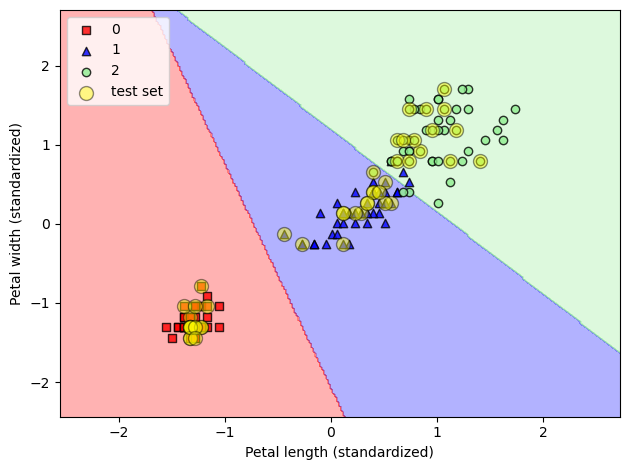

In [83]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs',
                        multi_class='ovr')

lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

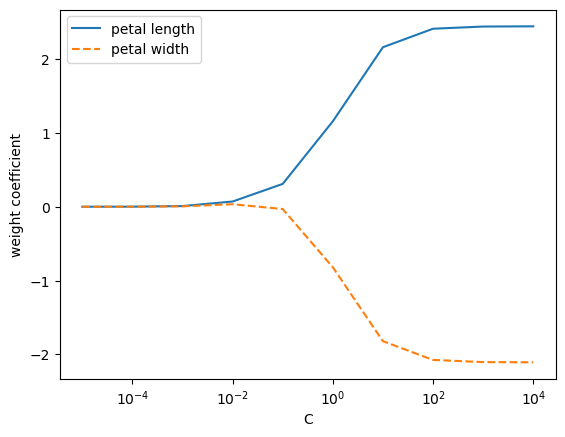

In [87]:
# Determine the parameter C

weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1,
                           solver='lbfgs', multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
        label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
        label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

# Support Vector Machine Model

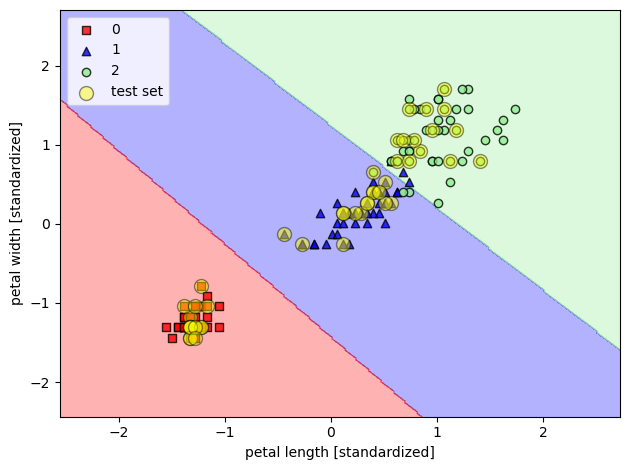

In [89]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=svm,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Solving Non-linear using Kernel SVM

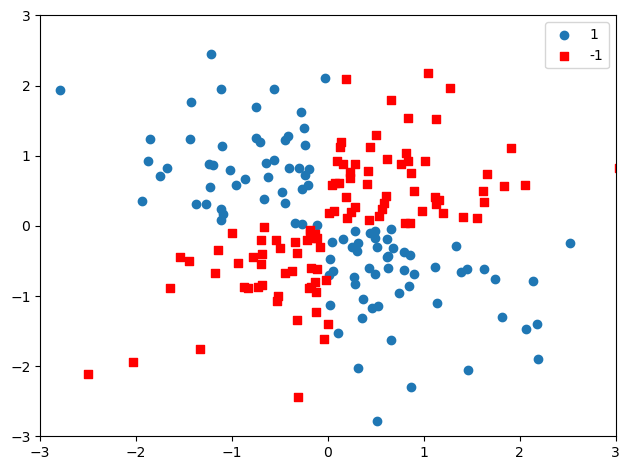

In [97]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

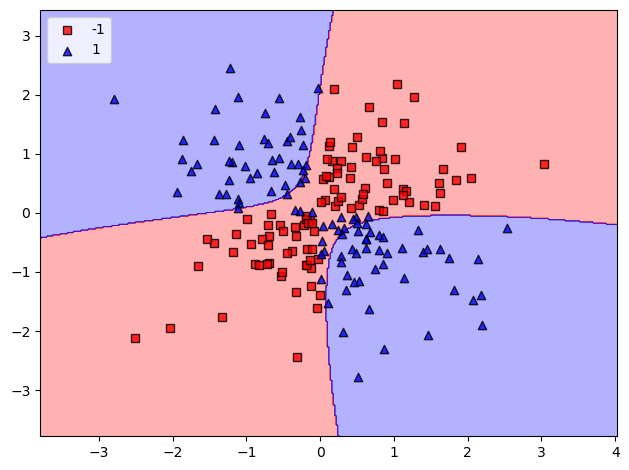

In [98]:
# Solve with kernel='rbf'

svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Decision Tree

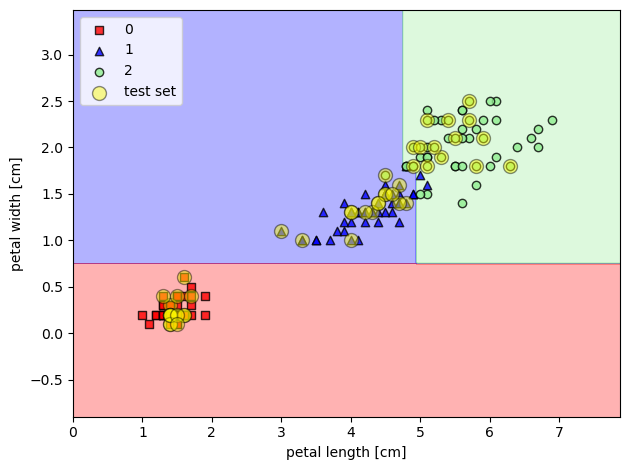

In [101]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini',
                                    max_depth=4,
                                    random_state=1)
tree_model.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined,
                      classifier=tree_model,
                      test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

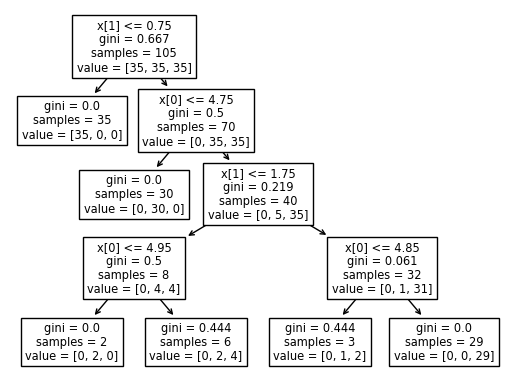

In [102]:
from sklearn import tree
tree.plot_tree(tree_model)
plt.show()